# <b> <center> <font color='#7B241C'> SIAMESE NETOWRK WITH CONTRASTIVE LOSS </font> </center> </b>

## <font color='blue'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Data Loading and Pre-processing](#4)
5. [Contrastive Loss](#5)
6. [Build and compile the model](#6)
7. [Training the model](#7)
8. [Making predictions](#8)
9. [Evaluation](#9)
10. [References](#references)

<a name="1"></a>
## <b> <font color='red'> 1. Introduction </font> </b>

We will implement a Siamese neural network to learn a similarity function for handwritten digits. Instead of classifying digits directly, the network learns to determine whether two input images belong to the same class or not.

We use contrastive loss to train the model, encouraging the network to produce similar embeddings for images of the same digit and dissimilar embeddings for images of different digits. This approach is useful for tasks like one-shot learning or verification systems, where comparing pairs is more relevant than classifying each input.

We'll work with the MNIST dataset and train the network using image pairs and binary labels indicating whether the digits match.


<a name="2"></a>
## <b> <font color='red'> 2. Setup </font> </b>

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

<a name="3"></a>
## <b> <font color='red'> 3. Helper Functions </font> </b>

In [25]:
# plot image pairs
def plot_image_pairs(pairs, labels, num_pairs=5):
    """
    Plots `num_pairs` image pairs with their labels.
    """
    plt.figure(figsize=(num_pairs * 2.5, 3))
    
    for i in range(num_pairs):
        pair = pairs[i]
        label = int(labels[i])
        
        # First image
        ax = plt.subplot(2, num_pairs, i + 1) # Top row: first image of pair
        plt.imshow(pair[0].squeeze(), cmap="gray")
        plt.axis("off")
        ax.set_title(f"Label: {label}")
        
        # Second image
        ax = plt.subplot(2, num_pairs, i + 1 + num_pairs) # Bottom row: second image of pair
        plt.imshow(pair[1].squeeze(), cmap="gray")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# plot history
def plot_history(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()


# plot images and prediction
def plot_image_pairs_with_predictions(pairs, true_labels, predictions, num_pairs=5):
    """
    Plots image pairs with their predicted similarity and true label.
    - `pairs`: list/array of image pairs [(img1, img2), ...]
    - `true_labels`: list/array of 0 or 1 labels
    - `predictions`: model predictions (probabilities or distances)
    """
    plt.figure(figsize=(num_pairs * 3, 4))
    
    for i in range(num_pairs):
        pair = pairs[i]
        true_label = int(true_labels[i])
        pred = predictions[i]
        
        # First image
        ax = plt.subplot(2, num_pairs, i + 1)
        plt.imshow(pair[0].squeeze(), cmap="gray")
        plt.axis("off")
        ax.set_title(f"True: {true_label}, Distance: {pred.item():.2f}")
        
        # Second image
        ax = plt.subplot(2, num_pairs, i + 1 + num_pairs)
        plt.imshow(pair[1].squeeze(), cmap="gray")
        plt.axis("off")
        #ax.set_title(f"Pred: {pred.item():.2f}")


    plt.tight_layout()
    plt.show()


<a name="4"></a>
## <b> <font color='red'> 4. Data Loading and Pre-processing </font> </b>

In [7]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

print(x_train.shape, x_test.shape)

# Add channel dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

x_train.shape, x_test.shape


(60000, 28, 28) (10000, 28, 28)


((60000, 28, 28, 1), (10000, 28, 28, 1))

We will generate pairs of images to train a model to recognize similarity. Each pair will consist of two images:

- If both images show the same digit, the pair is considered a positive pair and labeled with a 1.

- If the images show different digits, the pair is a negative pair and labeled with a 0.


In [8]:
# Function to create pairs (positive and negative)
def create_pairs(x, y):
    pairs = []
    labels = []
    num_classes = 10
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    for d in range(num_classes):
        for i in range(len(digit_indices[d]) - 1):
            # Positive pair
            idx1, idx2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs.append([x[idx1], x[idx2]])
            labels.append(1)

            # Negative pair
            neg_class = (d + 1) % num_classes
            idx1 = digit_indices[d][i]
            idx2 = np.random.choice(digit_indices[neg_class])
            pairs.append([x[idx1], x[idx2]])
            labels.append(0)
    return np.array(pairs), np.array(labels).astype("float32")

pairs_train, labels_train = create_pairs(x_train, y_train)
pairs_test, labels_test = create_pairs(x_test, y_test)

print("Pairs train shape:", pairs_train.shape)
print("Labels train shape:", labels_train.shape)

Pairs train shape: (119980, 2, 28, 28, 1)
Labels train shape: (119980,)


We can see that, for training, we have 1198980 pairs of images as features, where each image has a shape of 28×28×1.


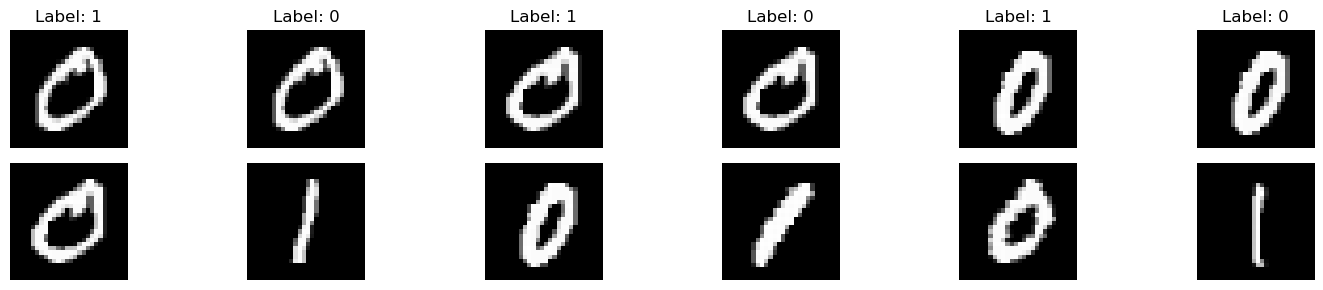

In [11]:
plot_image_pairs(pairs_train, labels_train, num_pairs=6)


<a name="5"></a>
## <b> <font color='red'> 5. Contrastive Loss </font> </b>

The goal of contrastive loss is to bring similar instances closer together in the embedding space and push apart dissimilar instances.

Contrastive loss is used to learn embeddings such that similar pairs are pulled closer and dissimilar pairs are pushed apart in the embedding space.

**Contrastive Loss**

Given two embeddings **x₁** and **x₂**, and a label **y**:

- y = 1 if they are similar
- y = 0 if they are dissimilar

The loss is defined as:

$$
L = y \cdot D^2 + (1 - y) \cdot \max(0, m - D)^2
$$

where:

- D is a distance
- m is a margin that defines how far apart dissimilar pairs should be.


In [13]:
# Contrastive loss (assumimg y_pred is the distance D, which will be in our case)
def contrastive_loss(y_true, y_pred, margin=1):
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

**Euclidean Distance**

Contrastive loss trains a Siamese network to pull similar samples closer in embedding space and push dissimilar ones apart. To do this, the network needs a way to measure how "far apart" two embeddings are — and that's where Euclidean distance comes in.

D is a distance, and the most commonly used with the constrative loss is the euclidean distance.

$$
D = \| x_1 - x_2 \|_2  $$ is the Euclidean distance between the embeddings.

In [14]:
# Compute Euclidean distance between embeddings
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, 1e-10))

<a name="6"></a>
## <b> <font color='red'> 6. Build and compile the model </font> </b>


We will build the following network:

<img src="images/SiameseNetworkWithLoss.png"/>



In [15]:
# Define the base network (simple CNN)
def base_network(input_shape):
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu")(input)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    return Model(input, x)

input_shape = x_train.shape[1:]
base_net = base_network(input_shape)

# Define inputs
input_a = layers.Input(shape=input_shape)
input_b = layers.Input(shape=input_shape)

# Get embeddings
processed_a = base_net(input_a)
processed_b = base_net(input_b)


distance = layers.Lambda(euclidean_distance)([processed_a, processed_b])

# Define the Siamese model
model = Model([input_a, input_b], distance)


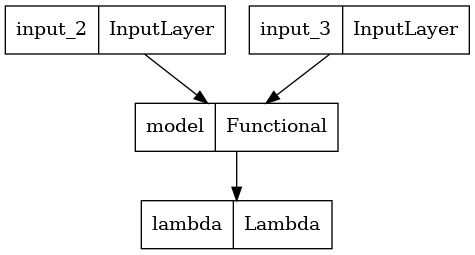

In [16]:
tf.keras.utils.plot_model(model)

In [17]:
# Compile
model.compile(loss=contrastive_loss, 
              optimizer="adam", 
              metrics=["accuracy"])

<a name="7"></a>
## <b> <font color='red'> 7. Training the model </font> </b>

In [19]:
# Prepare data for training
pair_1 = pairs_train[:, 0]  # all first images in the pairs
pair_2 = pairs_train[:, 1]  # all second images in the pairs

pair_1_test = pairs_test[:, 0]
pair_2_test = pairs_test[:, 1]

pair_1[i] and pair_2[i] give you the two images forming the i-th pair.

In [20]:
# Train
history = model.fit(
    [pair_1, pair_2], labels_train,
    validation_data=([pair_1_test, pair_2_test], labels_test),
    batch_size=128,
    verbose=0,
    epochs=8
)

2025-05-27 17:09:44.751001: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376257280 exceeds 10% of free system memory.
2025-05-27 17:09:46.586689: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376257280 exceeds 10% of free system memory.
2025-05-27 17:10:51.170284: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62657280 exceeds 10% of free system memory.
2025-05-27 17:10:51.234511: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62657280 exceeds 10% of free system memory.


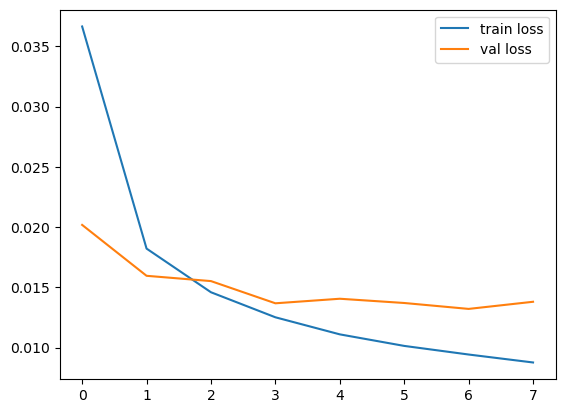

In [23]:
# Plot loss curve
plot_history(history)

<a name="8"></a>
## <b> <font color='red'> 8. Making predictions </font> </b>

Let's make a prediction with a test image.

In [24]:
img_id = 7

img1 = np.expand_dims(pair_1_test[img_id], axis=0)  # shape: (1, 28, 28, 1)
img2 = np.expand_dims(pair_2_test[img_id], axis=0)
pred = model.predict([img1, img2])
pred # is the euclidean distance


1/1 [==============================] - 0s 101ms/step


array([[1.142725]], dtype=float32)

We can see that the output is the distance between two processed inputs. 

Now, let's make a few predictions and plot the results.

1/1 [==============================] - 0s 20ms/step


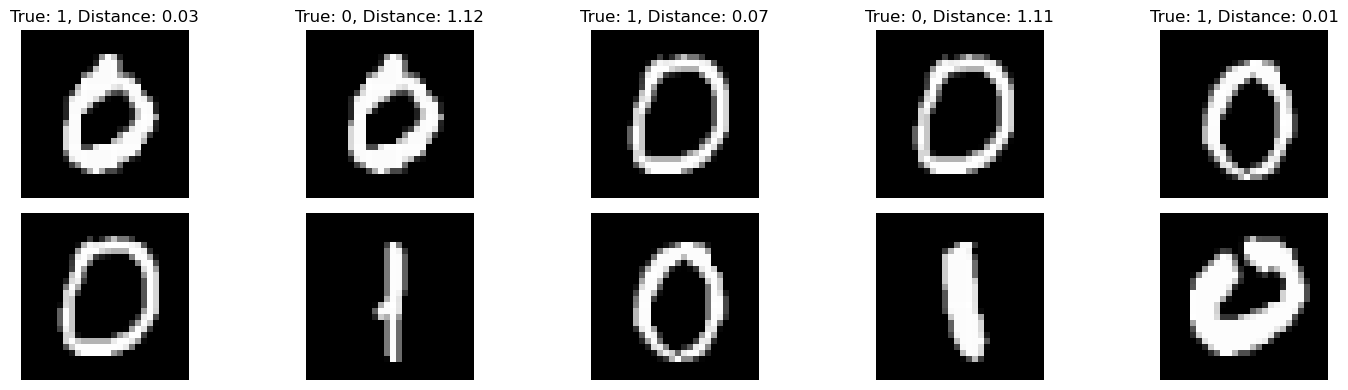

In [26]:
preds = model.predict([pair_1_test[:10], pair_2_test[:10]])
plot_image_pairs_with_predictions(pairs_test, labels_test, preds)


<a name="9"></a>
## <b> <font color='red'> 9. Evaluation </font> </b>

Let's compute the metrics:

In [27]:
distances = model.predict([pair_1_test, pair_2_test]).squeeze()  # shape: (N,)

  1/625 [..............................] - ETA: 13s

2025-05-27 17:29:35.872162: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62657280 exceeds 10% of free system memory.


625/625 [==============================] - 3s 5ms/step


In [28]:
threshold = 1.0  # you can tune this
binary_preds = (distances < threshold).astype(int)

In [30]:
y_true = labels_test

print("Accuracy:", accuracy_score(y_true, binary_preds))
print("Precision:", precision_score(y_true, binary_preds))
print("Recall:", recall_score(y_true, binary_preds))
print("F1 Score:", f1_score(y_true, binary_preds))
print("Confusion Matrix:\n", confusion_matrix(y_true, binary_preds))


Accuracy: 0.8259759759759759
Precision: 0.7418133214524393
Recall: 1.0
F1 Score: 0.8517713262565545
Confusion Matrix:
 [[6513 3477]
 [   0 9990]]


<br>

Recall = 1.0: The network never misses a positive pair (pairs of images it should recognize as "same digit"). This means all true pairs were detected as similar.

Precision = 0.742: About 74% of pairs predicted as "same digit" were correct. So, 26% were false positives—pairs predicted similar but actually different digits.

Confusion Matrix details:

- TN = 6513: Correctly identified different-digit pairs as different.

- FP = 3477: Different-digit pairs misclassified as same (false alarms).

- FN = 0: No same-digit pairs missed.

- TP = 9990: Correctly identified same-digit pairs.

What this tells us about the Siamese net on MNIST:

- High recall and zero FN is great: Your network successfully retrieves all matching digit pairs.

- False positives are still high: 3477 different pairs were classified as similar. This means the embedding space or threshold might be too loose, causing confusion among different digits.
- Since MNIST digits can be visually similar (e.g., 1 vs 7, 3 vs 5), the model struggles to fully separate dissimilar pairs.

**Note.** The confusion matrix is 2×2 because the labels are binary:

- 1 means "same" (the two images belong to the same class)

- 0 means "different" (the two images belong to different classes)

Let's tune the threshold.

In [31]:
# Tune threshold

best_thresh = 0
best_f1 = 0

for t in np.linspace(0.1, 2.0, 50):
    preds = (distances < t).astype(int)
    f1 = f1_score(y_true, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold: {best_thresh:.2f}, Best F1: {best_f1:.2f}")


Best threshold: 0.57, Best F1: 0.99


<a name="references"></a>
## <b> <font color='red'> References </font>  </b>

[Deep Learning Specialization](https://www.coursera.org/learn/convolutional-neural-networks?specialization=deep-learning)
